In [130]:
import ast
import json
import os
import shutil

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import torch
from PIL import Image
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa

In [54]:
base_config = {
    "EFFB7": {
        "IMG_SIZE": 600,
        "BATCH_SIZE": 16,
        "SEED": 42,
        "WEIGHTS": "/app/_data/efficientnet-b7_noisy-student_notop.h5",
    },
    "CLASS": {"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3},
}

In [55]:
file_json = open("/app/_data/base_config.json", "w")
json.dump(base_config, file_json)
file_json.close()

In [4]:
list_bad = [
    "f00655c68e05.jpg",
    "b6f989cfd190.jpg",
    "5cae48f87eb1.jpg",
    "f5af0ed4c2db.jpg",
    "57675376af04.jpg",
    "0c22dc834dea.jpg",
]

In [5]:
train = pd.read_csv("/app/_data/train.csv")

In [6]:
# os.mkdir("/app/_data/train_npy/")

In [7]:
train["class_id"] = train["class"].replace(base_config["CLASS"])

In [8]:
class Aug:
    def augment_image(img):
        h = img.shape[0]
        w = img.shape[1]
        transform = albumentations.Compose(
            [
                albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
                albumentations.OneOf(
                    [
                        albumentations.MotionBlur((3, 5)),
                        albumentations.MedianBlur(blur_limit=5),
                        albumentations.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                        albumentations.Blur(blur_limit=(3, 5)),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.GaussNoise(var_limit=[10, 20], mean=1),
                        albumentations.ImageCompression(
                            quality_lower=70, quality_upper=100, compression_type=1
                        ),
                        albumentations.MultiplicativeNoise(
                            multiplier=(0.95, 1.05), per_channel=False, elementwise=True
                        ),
                        albumentations.Downscale(
                            scale_min=0.8, scale_max=0.99, interpolation=4
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.RandomBrightnessContrast(
                            brightness_limit=0.2,
                            contrast_limit=0.2,
                            brightness_by_max=True,
                        ),
                        albumentations.augmentations.transforms.Sharpen(
                            alpha=(0.05, 0.15), lightness=(0.5, 1.0), p=1
                        ),
                        albumentations.augmentations.transforms.RandomToneCurve(
                            scale=0.15
                        ),
                    ],
                    p=0.2,
                ),
                albumentations.RandomSizedCrop(
                    min_max_height=(0.9 * h, 0.9 * w),
                    height=h,
                    width=w,
                    w2h_ratio=1.0,
                    interpolation=0,
                    p=0.2,
                ),
                albumentations.OneOf(
                    [
                        albumentations.OpticalDistortion(
                            distort_limit=0.1,
                            shift_limit=0.1,
                            border_mode=0,
                        ),
                        albumentations.ElasticTransform(
                            alpha=2.0,
                            sigma=2.0,
                            alpha_affine=2.0,
                            interpolation=0,
                            border_mode=0,
                        ),
                        albumentations.GridDistortion(
                            num_steps=5,
                            distort_limit=0.3,
                            interpolation=0,
                            border_mode=0,
                        ),
                    ],
                    p=0.3,
                ),
                albumentations.OneOf(
                    [
                        albumentations.Rotate(
                            limit=(-10, 10), interpolation=0, border_mode=0
                        ),
                        albumentations.ShiftScaleRotate(
                            shift_limit=0.1,
                            scale_limit=0.1,
                            rotate_limit=10,
                            interpolation=0,
                            border_mode=0,
                        ),
                        albumentations.augmentations.crops.transforms.CropAndPad(
                            px=None,
                            percent=(-0.15, 0.1),
                            pad_mode=0,
                            pad_cval=0,
                            pad_cval_mask=0,
                            keep_size=True,
                            sample_independently=True,
                            interpolation=1,
                        ),
                        albumentations.RandomSizedCrop(
                            min_max_height=(0.9 * h, 0.9 * w),
                            height=h,
                            width=w,
                            w2h_ratio=1.0,
                            interpolation=0,
                        ),
                    ],
                    p=0.3,
                ),
            ]
        )

        return transform(image=img)["image"]

In [9]:
train[
    [
        "id_image",
        "boxes",
        "StudyInstanceUID",
        "image",
        "class",
        "path",
        "modality",
        "PatientSex",
        "BodyPartExamined",
        "PhotometricInterpretation",
        "width",
        "height",
        "n_bbox",
        "class_id",
    ]
]

,id_image,boxes,StudyInstanceUID,image,class,path,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height,n_bbox,class_id
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",5776db0cec75,000a312787f2.dcm,typical,/app/_data/train/5776db0cec75/81456c9c5423/000...,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,2,1
1,000c3a3f293f_image,NaN,ff0879eb20ed,000c3a3f293f.dcm,negative,/app/_data/train/ff0879eb20ed/d8a644cc4f93/000...,CR,M,CHEST,MONOCHROME2,2832.0,2320.0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",9d514ce429a7,0012ff7358bc.dcm,typical,/app/_data/train/9d514ce429a7/22897cd1daa0/001...,DX,F,PORT CHEST,MONOCHROME2,3056.0,2544.0,2,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",28dddc8559b2,001398f4ff4f.dcm,atypical,/app/_data/train/28dddc8559b2/4d47bc042ee6/001...,CR,F,CHEST,MONOCHROME1,4280.0,3520.0,1,3
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",dfd9fdd85a3e,001bd15d1891.dcm,typical,/app/_data/train/dfd9fdd85a3e/49170afa4f27/001...,DX,M,CHEST,MONOCHROME1,3408.0,2800.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,7e6c68462e06,ffcc6edd9445.dcm,negative,/app/_data/train/7e6c68462e06/98011bca5fd2/ffc...,CR,F,CHEST,MONOCHROME2,3480.0,4240.0,0,0
6330,ffd91a2c4ca0_image,NaN,8332bdaddb6e,ffd91a2c4ca0.dcm,negative,/app/_data/train/8332bdaddb6e/f346cda52da0/ffd...,DX,F,CHEST,MONOCHROME1,3408.0,2800.0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",7eed9af03814,ffd9b6cf2961.dcm,typical,/app/_data/train/7eed9af03814/668a64e3a5fa/ffd...,DX,M,TORAX,MONOCHROME2,3050.0,2388.0,3,1
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",a0cb0b96fb3d,ffdc682f7680.dcm,typical,/app/_data/train/a0cb0b96fb3d/ccf363aa080f/ffd...,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,2,1


In [11]:
with open("/app/src/dict_metadata.json", "r") as f:
    dict_metadata = json.load(f)

In [50]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        batch_size,
        img_size,
        seed,
        prepared_img_path,
        shuffle=False,
        augment=False,
    ):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.seed = seed
        self.prepared_img_path = prepared_img_path
        self._shuffle = shuffle
        self.augment = augment

        if not os.path.exists(self.prepared_img_path):
            os.mkdir(self.prepared_img_path)

    def on_epoch_start(self):
        if self._shuffle:
            self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(
                drop=True
            )

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def make_img(self, img_name):
        try:
            img = np.load(self.prepared_img_path + img_name + ".npy")
        except:
            img = tf.io.read_file("/app/_data/jpg/" + img_name + ".jpg")
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(
                img,
                (self.img_size, self.img_size),
            )
            img = tf.cast(img, tf.uint8)
            img = img.numpy()
            np.save(self.prepared_img_path + img_name, img)
        return img

    def _get_one(self, ix):
        img_name = self.df.loc[ix, "image"][:-4]
        class_id = self.df.loc[ix, "class"]
        modality = self.df.loc[ix, "modality"]
        PatientSex = self.df.loc[ix, "PatientSex"]
        body_part = self.df.loc[ix, "BodyPartExamined"]
        img = self.make_img(img_name)
        x = {}
        with open("/app/_data/dict_metadata.json", "r") as f:
            dict_metadata = json.load(f)
        if self.augment:
            img = Aug.augment_image(img)
        patient_sex_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")
        body_part_x = np.zeros(len(dict_metadata["BodyPartExamined"]), dtype="uint8")
        modality_x = np.zeros(len(dict_metadata["PatientSex"]), dtype="uint8")

        if PatientSex in dict_metadata["PatientSex"].keys():
            patient_sex_x[dict_metadata["PatientSex"][PatientSex]] = 1
        else:
            patient_sex_x[dict_metadata["PatientSex"]["unknown"]] = 1
        if body_part in dict_metadata["BodyPartExamined"].keys():
            body_part_x[dict_metadata["BodyPartExamined"][body_part]] = 1
        else:
            body_part_x[dict_metadata["BodyPartExamined"]["unknown"]] = 1
        if modality in dict_metadata["modality"].keys():
            modality_x[dict_metadata["modality"][modality]] = 1
        else:
            modality_x[dict_metadata["modality"]["unknown"]] = 1
        x["img"] = img
        x["data"] = np.concatenate([patient_sex_x, body_part_x, modality_x])
        y = np.zeros(4, dtype="uint8")
        y[dict_metadata["class"][class_id]] = 1
        return x, y

    def __getitem__(self, batch_ix):

        x, y = {}, []
        b_x_img = []
        b_x_data = []
        for i in range(self.batch_size):
            x_dict, y_ = self._get_one(i + self.batch_size * batch_ix)
            b_x_img.append(x_dict["img"])
            b_x_data.append(x_dict["data"])
            y.append(y_)
        x["img"] = np.array(b_x_img)
        x["data"] = np.array(b_x_data)
        y = np.array(y)

        return x, y

In [66]:
gen = Generator(
    df=train,
    prepared_img_path="/app/_data/train_jpg_600/",
    batch_size=base_config["EFFB7"]["BATCH_SIZE"],
    img_size=base_config["EFFB7"]["IMG_SIZE"],
    seed=base_config["EFFB7"]["SEED"],
    shuffle=False,
    augment=True,
)

In [68]:
a = gen.__getitem__(4)

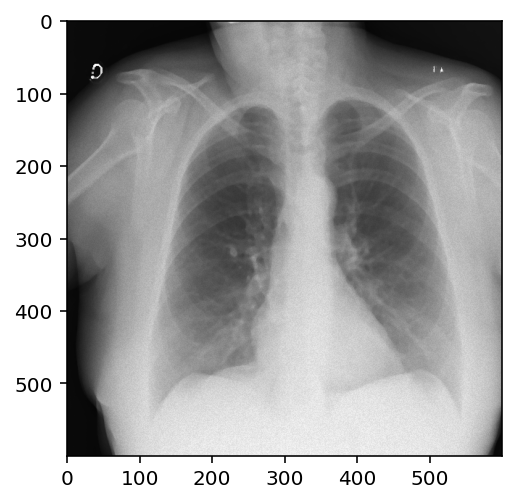

In [73]:
plt.imshow(a[0]["img"][1])

In [132]:
class GetModel:
    def __init__(self, model_name):
        self.model_name = model_name

    def get_model(self):
        model_name  =self.model_name
        with open("/app/_data/base_config.json", "r") as f:
            base_config = json.load(f)

        IMG_SIZE = base_config[model_name]["IMG_SIZE"]
        weights_path = base_config[model_name]["WEIGHTS"]

        if model_name == "EFFB7":
            base_model = keras.applications.EfficientNetB7(
                weights=None, include_top=False
            )
        elif model_name == "EFFB4":
            base_model = keras.applications.EfficientNetB4(
                weights=None, include_top=False
            )
        base_model.load_weights(
            weights_path,
            by_name=True,
            skip_mismatch=True,
        )
        input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="img")
        x_img = base_model(input_img)
        x_img = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x_img)

        input_data = keras.Input(shape=18, name="data")
        x_data = keras.layers.Dense(32, activation="relu", name="dense_data_1")(
            input_data
        )
        x_data = keras.layers.Dense(32, activation="relu", name="dense_data_2")(x_data)
        x_data = keras.layers.Dense(32, activation="relu", name="dense_data_3")(x_data)
        x = keras.layers.Concatenate(axis=1, name="all")(
            [
                x_img,
                x_data,
            ]
        )
        outputs = keras.layers.Dense(4, activation="sigmoid")(x)
        model = keras.Model(inputs=[input_img, input_data], outputs=outputs)
        model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(lr=0.005),
            metrics=[
                "acc",
                keras.metrics.Recall(),
                keras.metrics.Precision(),
                tfa.metrics.F1Score(num_classes=4, average="weighted"),
            ],
        )
        return model

    def make_callback(self,
        model_path,
        tensorboard_path = '/app/.tensorboard/',
        patience_ES = 12,
        patience_RLR = 5,
        factor_LR = 0.9,
        metric_for_monitor='val_loss',
        metric_mode = 'min'
        
    ):
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        else:
            print('Warning! Model path already exists.')
        callbacks = [
        keras.callbacks.EarlyStopping(
            monitor=metric_for_monitor,
            patience=patience_ES,
            restore_best_weights=True,
            verbose=1,
            mode=metric_mode,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = model_path,
            monitor=metric_for_monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode=metric_mode,
            save_freq="epoch",
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor=metric_for_monitor,
            factor=factor_LR,
            patience=patience_RLR,
            verbose=1,
            mode=metric_mode,
            min_delta=1e-5,
            min_lr=0.00000001,
        ),
        keras.callbacks.TensorBoard(log_dir=tensorboard_path, histogram_freq=0),
        keras.callbacks.experimental.BackupAndRestore(model_path+"backup/"),
        keras.callbacks.TerminateOnNaN(),
    ]
        return callbacks

In [133]:
# Get_Model = GetModel
model = GetModel("EFFB7").get_model()

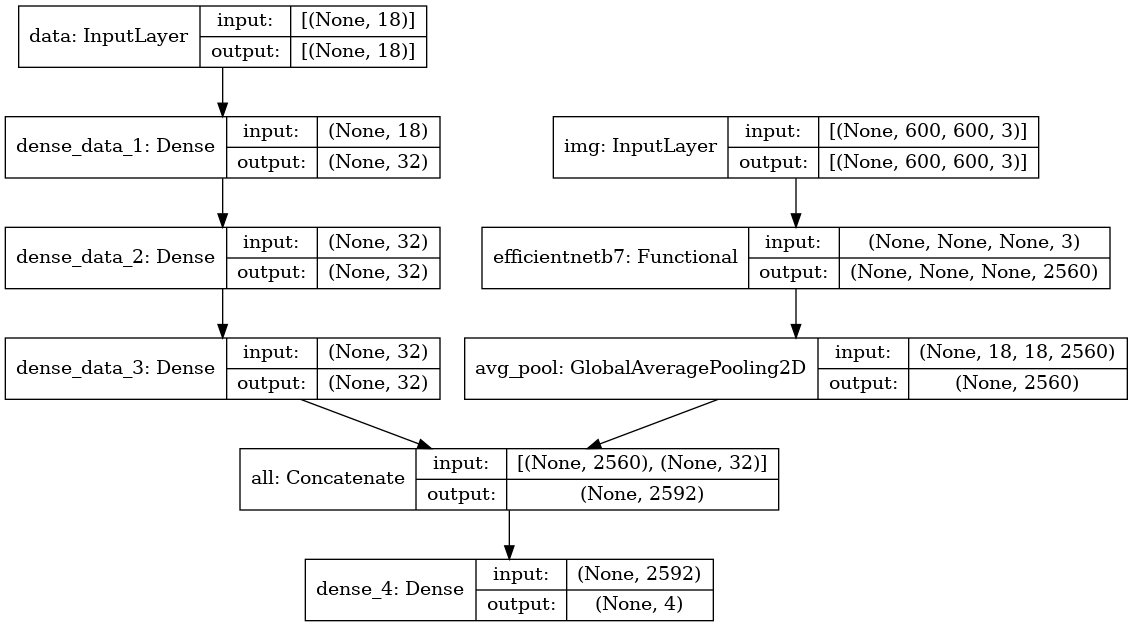

In [138]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [110]:
c = Get_Model.make_callback(
    model_path="/app/_data/models/EffB7_init/",
    tensorboard_path="/app/.tensorboard/EffB7_init_0",
    patience_ES=12,
    patience_RLR=5,
    factor_LR=0.9,
    metric_for_monitor="val_loss",
    metric_mode="min",
)

Warning! Model path already exists.


In [109]:
c

In [56]:
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 16,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b7_noisy-student_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3}}

In [12]:
dict_metadata

{'modality': {'CR': 0, 'DX': 1, 'unknown': 2},
 'PatientSex': {'F': 0, 'M': 1, 'unknown': 2},
 'BodyPartExamined': {'2- TORAX': 0,
  'ABDOMEN': 1,
  'CHEST': 2,
  'PECHO': 3,
  'PORT CHEST': 4,
  'Pecho': 5,
  'SKULL': 6,
  'T?RAX': 7,
  'THORAX': 8,
  'TORAX': 9,
  'TÒRAX': 10,
  'unknown': 11}}

In [75]:
from src.utils import Aug, Generator, GetModel

In [76]:
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 16,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b7_noisy-student_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3}}

In [77]:
gen = Generator(
    df=train,
    batch_size=base_config["EFFB7"]["BATCH_SIZE"],
    seed=base_config["EFFB7"]["SEED"],
    img_size=base_config["EFFB7"]["IMG_SIZE"],
    prepared_img_path="/app/_data/train_jpg_600/",
    shuffle=True,
    augment=True,
)

In [84]:
a = gen.__getitem__(11)

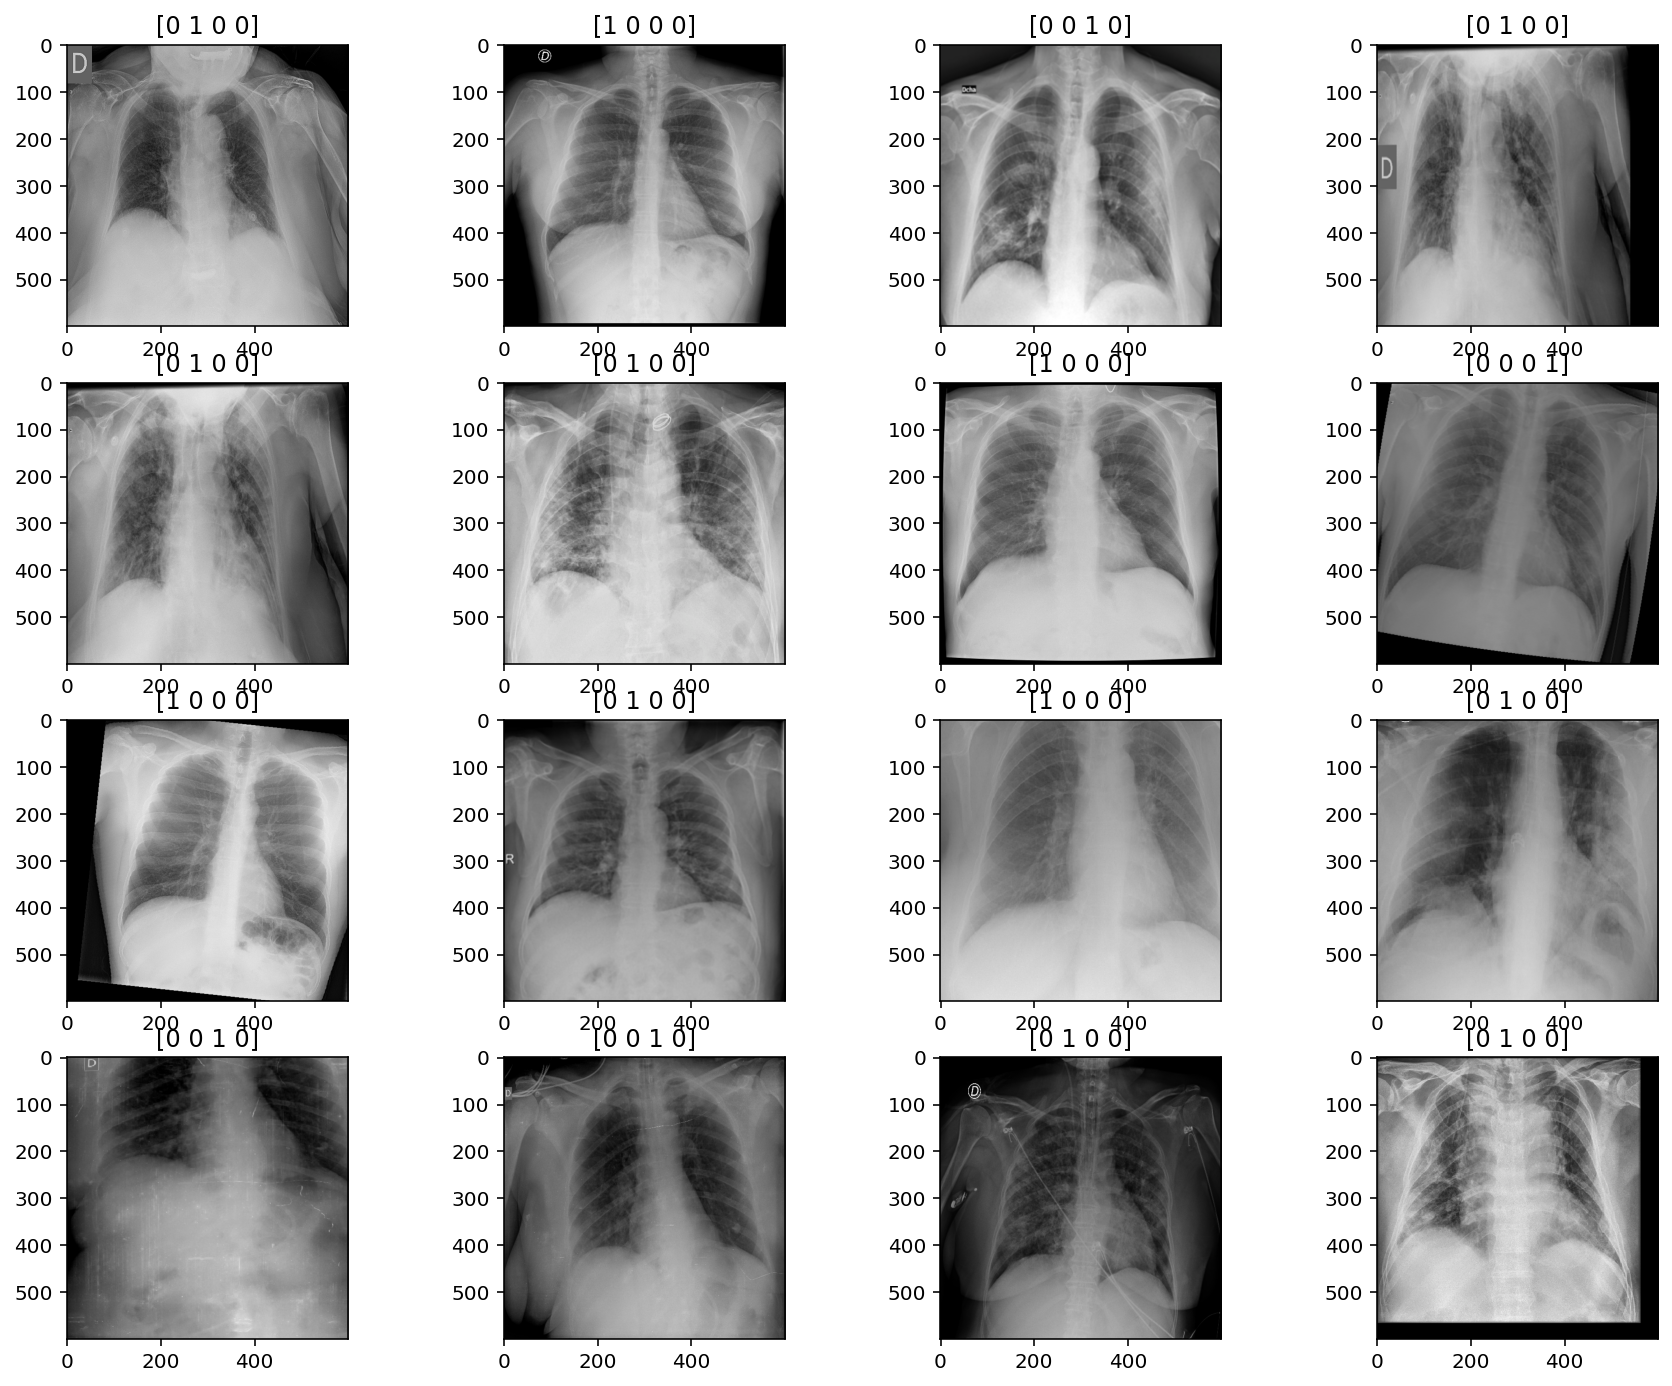

In [85]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(5, 4, i + 1)
    plt.title(a[1][i])
    plt.imshow(a[0]["img"][i])